$ q(M) = \prod_i \prod_j q(M_{ij}) =  \prod_i \prod_j Bern(\theta_{ij}) $


$ p(M) = \prod_i \prod_j Bern(0.999)  $

$ ELBO = E_{q(M)}[logp(c | X, M)] + \lambda KL(q(M) || p(M)) $


In [1]:
from __future__ import print_function

# MNIST example

We will perform a simple analysis on MNIST to identify which pixels to erase to convert digits from one class into another class. We will compare importance scores computed using a variety of methods.

## Obtain data and keras model

We will load a keras model and compute importance scores

### Download the keras model

Download a model with 2 strided convolutional layers and 2 dense layers, similar to the one in the paper.

### Load the keras model

In [3]:
import keras
keras_model = keras.models.load_model("model/mnist_cnn_allconv.h5")
keras_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 13, 13)    544         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 13, 13)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 5, 5)      32832       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 64, 5, 5)      0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [4]:
import torch

### Load the data

In [5]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test = X_test[:,None,:,:]
X_test = X_test / 255.

## Prepare the deeplift models

### Model conversion

Convert the keras models to deeplift models capable of computing importance scores using DeepLIFT-RevealCancel, gradients and guided backprop

In [6]:
import deeplift
from deeplift.blobs import NonlinearMxtsMode
from deeplift.conversion import keras_conversion as kc

#Three different models, one each for RevealCancel, Gradient and GuidedBackprop
revealcancel_model = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
grad_model = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.Gradient)
guided_backprop_model = kc.convert_sequential_model(model=keras_model, nonlinear_mxts_mode=NonlinearMxtsMode.GuidedBackprop)

nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Gradient
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: GuidedBackprop
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case


### Sanity checks

To ensure that the conversion happend correctly, ensure that the models give identical predictions

In [7]:
from deeplift.util import compile_func
import numpy as np
from keras import backend as K

deeplift_model = revealcancel_model
deeplift_prediction_func = compile_func([deeplift_model.get_layers()[0].get_activation_vars()],
                                       deeplift_model.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(X_test, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[X_test],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

difference in predictions: 0.0


## Compute importance scores

### Compile various scoring functions

Using the deeplift models, we obtain the functions capable of computing the importance scores.

In [8]:
from keras import backend as K
import deeplift
from deeplift.util import get_integrated_gradients_function

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
grad_times_inp_func = grad_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
guided_backprop_times_inp_func = guided_backprop_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

gradient_func = grad_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)
guided_backprop_func = guided_backprop_model.get_target_multipliers_func(find_scores_layer_idx=0, target_layer_idx=-2)

#pure-gradients or pure-guidedbackprop perform rather poorly because they produce scores on pixels that are 0 (which are
#the backround in MNIST). But we can give them a slight advantage by masking out positions that
#are zero. Also, the method of simonyan et al uses the magnitude of the gradient.
simonyan_func_masked = lambda input_data_list, **kwargs: ((input_data_list[0]>0.0)*
                        np.abs(np.array(gradient_func(input_data_list=input_data_list,**kwargs))))
guided_backprop_func_masked = lambda input_data_list, **kwargs: ((input_data_list[0]>0.0)*
                               guided_backprop_func(input_data_list=input_data_list, **kwargs))

#prepare the integrated gradients scoring function
#heads-up: these take 5x and 10x longer to compute respectively!
integrated_grads_5 = get_integrated_gradients_function(gradient_func, 5)
integrated_grads_10 = get_integrated_gradients_function(gradient_func, 10)

### Call scoring functions on the data

In [9]:
from collections import OrderedDict
method_to_task_to_scores = OrderedDict()
print("HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively")
print("Consider leaving them out to get faster results")
for method_name, score_func in [
                               ('revealcancel', revealcancel_func),
#                                ('guided_backprop_masked', guided_backprop_func_masked),
#                                ('guided_backprop_times_inp', guided_backprop_times_inp_func),
#                                ('simonyan_masked', simonyan_func_masked), 
#                                ('grad_times_inp', grad_times_inp_func),
#                                ('integrated_grads_5', integrated_grads_5),
#                                ('integrated_grads_10', integrated_grads_10)
]:
    print("Computing scores for:",method_name)
    method_to_task_to_scores[method_name] = {}
    for task_idx in range(10):
        print("\tComputing scores for task: "+str(task_idx))
        scores = np.array(score_func(
                    task_idx=task_idx,
                    input_data_list=[X_test],
                    input_references_list=[np.zeros_like(X_test)],
                    batch_size=1000,
                    progress_update=None))
        method_to_task_to_scores[method_name][task_idx] = scores

HEADS UP! integrated_grads_5 and integrated_grads_10 take 5x and 10x longer to run respectively
Consider leaving them out to get faster results
Computing scores for: revealcancel
	Computing scores for task: 0
	Computing scores for task: 1
	Computing scores for task: 2
	Computing scores for task: 3
	Computing scores for task: 4
	Computing scores for task: 5
	Computing scores for task: 6
	Computing scores for task: 7
	Computing scores for task: 8
	Computing scores for task: 9


## Plot figures

### Prepare various functions to aid in plotting

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras import backend as K


#Function to plot scores of an MNIST figure
def viz_scores(scores,ax):
    reshaped_scores = scores.reshape(28,28)
    the_min = np.min(reshaped_scores)
    the_max = np.max(reshaped_scores)
    center = 0.0
    negative_vals = (reshaped_scores < 0.0)*reshaped_scores/(the_min + 10**-7)
    positive_vals = (reshaped_scores > 0.0)*reshaped_scores/float(the_max)
    reshaped_scores = -negative_vals + positive_vals
    ax.imshow(-reshaped_scores, cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])

#Function that masks out the top n pixels where the score for
#task_1 is higher than the score for task_2
def get_masked_image(idx, scores, task_1, task_2, n_to_erase):
    difference = scores[task_1][idx].ravel() - scores[task_2][idx].ravel()
    #highlight the top n
    top_nth_threshold = max(sorted(difference, key=lambda x: -x)[n_to_erase],0.0)
    thresholded_points = 1.0*(difference <= top_nth_threshold)
    masked_inp = thresholded_points.reshape(1,28,28)*X_test[idx]
    return masked_inp

#Function to plot the result of masking on a single example, for converting
#from task1->task2 and task1->task3
def plot_two_way_figures(idx, task_1, task_2, task_3, method_names, n_to_erase):
    print("example index: "+str(idx))
    print("Order of columns is:","task "+str(task_1)+" scores","task "+str(task_2)+" scores",
                                 str(task_1)+"->"+str(task_2)+" masking",
                                 "task "+str(task_3)+" scores", str(task_1)+"->"+str(task_3)+" masking")
    print("Order of the methods is: "+", ".join(str(x) for x in method_names))
    for method_name in method_names:
        scores = method_to_task_to_scores[method_name]
        mean_scores_over_all_tasks = np.mean(np.array([scores[i][idx] for i in range(10)]), axis=0)
        f, axarr = plt.subplots(1, 6, sharey=False, figsize=(15,10))
        viz_scores(X_test[idx], axarr[0])
        
        viz_scores(scores[task_1][idx] - mean_scores_over_all_tasks, axarr[1])
        viz_scores(scores[task_2][idx] - mean_scores_over_all_tasks, axarr[2])
        viz_scores(get_masked_image(idx, scores, task_1, task_2, n_to_erase), axarr[3])
        viz_scores(scores[task_3][idx] - mean_scores_over_all_tasks, axarr[4])
        viz_scores(get_masked_image(idx, scores, task_1, task_3, n_to_erase), axarr[5])
    plt.show()
    
#Function to compute change in log-odds scores after
#pixels have been masked to convert from original_class to target_class
def compute_delta_log_odds(X, y, predict_func, imp_scores,
                           original_class, target_class,
                           num_perturbations):
    original_class_mask = y_test==original_class
    X = np.compress(condition=original_class_mask,
                                  a=X,axis=0)
    
    
    #compute log-odds of model for those two classes
    predictions = np.array(deeplift.util.run_function_in_batches(predict_func,
                                                        input_data_list=[X],
                                                        batch_size=200, progress_update=None))
    orig_log_odds = predictions[:,original_class] - predictions[:,target_class]
    #make num_perturbations to move from original_class
    #to target_class according to imp_scores
    #first, get the difference of imp_scores for the two classes
    diff_of_scores = (np.compress(original_class_mask, imp_scores[original_class].reshape((-1, 784)), axis=0) - 
                      np.compress(original_class_mask, imp_scores[target_class].reshape((-1, 784)), axis=0))
    modified_inp = []
    #then, for each example, sort the scores and zero out indices
    for inp, diff_of_scores in zip(X, diff_of_scores):
        top_nth_threshold = max(sorted(diff_of_scores, key=lambda x: -x)[num_perturbations], 0.0)
        thresholded_points = 1.0*(diff_of_scores <= top_nth_threshold)
        modified_inp.append(thresholded_points.reshape(1,28,28)*inp)
    modified_inp = np.array(modified_inp)
    
    #assess change in log-odds for the modified images
    new_predictions = np.array(deeplift.util.run_function_in_batches(predict_func,
                                                        input_data_list=[modified_inp],
                                                        batch_size=200, progress_update=None))
    new_log_odds = new_predictions[:,original_class] - new_predictions[:,target_class]
    print(new_predictions)
    print(predictions)
    to_return = orig_log_odds - new_log_odds
    return (to_return,
            sum(new_log_odds < 0.0)/float(len(new_log_odds)),
            new_predictions[:,[original_class, target_class]],
            predictions[:,[original_class, target_class]])

#pre_softmax_func computes the output of the linear layer preceding the
#Final softmax noninearity
pre_softmax_func_inner = K.function([keras_model.input, K.learning_phase()],
                                    [keras_model.layers[-2].output])
pre_softmax_func = lambda x: pre_softmax_func_inner([x, False])[0]

def barplot_scores(original_class, target_class, method_names_and_short_names, n_to_erase):
    print("converting: "+str(original_class)+"->"+str(target_class))
    method_names = [x[0] for x in method_names_and_short_names]
    short_names = [x[1] for x in method_names_and_short_names]
    original_class_mask = y_test==original_class
    scores_to_plot = []
    fig, ax = plt.subplots(figsize=(2*len(method_names),5))
    
    for method_name in method_names:
        if method_name.startswith('p_b') or method_name.startswith('vbd'):
            score = torch.load('result/deeplift-%d-%d-%s.pkl' % (original_class, target_class, method_name))
            scores_to_plot.append(score)
            continue

        logodds_diff, flipped, new_predictions, old_predictions = compute_delta_log_odds(
                                                                     X=X_test, y=y_test,
                                                                     predict_func=pre_softmax_func,
                                                                     imp_scores=method_to_task_to_scores[method_name],
                                                                     original_class=original_class,
                                                                     target_class=target_class,
                                                                     num_perturbations=n_to_erase)
        #figure out indices with big shifts
        retained_indices = np.compress(condition=original_class_mask, a=np.arange(len(y_test)))

        #sorted_shifts
        sorted_shifts = sorted(enumerate(zip(logodds_diff,new_predictions,old_predictions)), key=lambda x: -x[1][0])
        print("top indices for "+str(method_name)+": "+" ".join([str(retained_indices[x[0]]) for x in sorted_shifts[:10]]))
        scores_to_plot.append(logodds_diff)
    ax.boxplot(scores_to_plot, widths=[0.5 for x in method_names])
#     ax.set_ylim(-1000,17000)
    ax.set_ylabel("Change in log-odds")
    ax.set_xticklabels(short_names)
    plt.title(str(original_class)+" --> "+str(target_class), fontsize=24)
    plt.tick_params(labelsize=17)
    plt.show()
    return scores_to_plot

In [11]:
import sys
import os
from os import path
sys.path.append(path.dirname(path.dirname(os.getcwd())))
import exp.utils_visualise as utils_visualise

def get_top_masked_images(source, target, num_imgs=6):
    results = []
    
    idxs = np.compress(a=range(len(y_test)), condition= (y_test == source), axis=0)
    
    for i in xrange(num_imgs):
        orig_img = X_test[idxs[i], 0, ...]
        
        img = get_masked_image(idxs[i], method_to_task_to_scores['revealcancel'], source, target, n_to_erase=157)
        
        overlayed_img, clim = utils_visualise.overlay(orig_img, img[0, ...])
        results.append(torch.from_numpy(overlayed_img))
    return results

import exp.utils_visualise as utils_visualize
from deeplift_compare import run
from deeplift_compare import parse_args

args = parse_args()
print(args)

def visualize(source, target, num_imgs=6):
    results = OrderedDict()
    
    revealcancel_masked = get_top_masked_images(source, target, num_imgs=num_imgs)
    results['DeepLift\nReveal Cancel'] = revealcancel_masked
    
    args.top_n = 6
    args.verbose = 0
    args.model = 'p_b'
    args.from_digit = source
    args.to_digit = target
    
    # Running perturbation    
    args.window = 1
    diff, overlayed_imgs = run(args)
    results['Perturbation\nWindow 1'] = overlayed_imgs
    args.window = 2
    diff, overlayed_imgs = run(args)
    results['Perturbation\nWindow 2'] = overlayed_imgs
    args.window = 3
    diff, overlayed_imgs = run(args)
    results['Perturbation\nWindow 3'] = overlayed_imgs
    
    args.window = 1
    args.model = 'vbd'
    diff, overlayed_imgs = run(args)
    results['VarBinaryDropout'] = overlayed_imgs
    
    args.window = 2
    args.model = 'vbd_window'
    diff, overlayed_imgs = run(args)
    results['VarBinaryDropout\nWindow 2'] = overlayed_imgs

    args.window = 3
    args.model = 'vbd_window'
    diff, overlayed_imgs = run(args)
    results['VarBinaryDropout\nWindow 3'] = overlayed_imgs
    
    vals = []
    for v in results.values():
        vals += v

    plt.figure(figsize=(30,10))
    utils_visualize.save_figs(vals, filename='', visualize=True, nrow=num_imgs)
    plt.xticks([])
    labels = results.keys()
    pos = [15 + i * 30 for i in xrange(len(labels))]
    plt.yticks(pos, labels)
    plt.show()

cuda: False
Namespace(cuda=False, from_digit=8, l1_reg_coef=0.1, l2_reg_coef=0.0, model='vbd', no_cuda=True, to_digit=3, top_n=1, verbose=1, visualize=True, window=2)


load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[38.384214878082275, 19.3890061378479, 33.40637731552124, 36.77999806404114, 33.597527503967285, 30.520543575286865]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[38.58042573928833, 22.80769634246826, 33.485536336898804, 39.83755540847778, 35.74968099594116, 27.149850845336914]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[37.595407485961914, 19.992982864379883, 35.287389278411865, 42.75429010391235, 34.92667818069458, 27.732370615005493]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[46.70260810852051, 32.068172454833984, 37.96287679672241, 36.70254421234131, 38.35729503631592, 24.922672748565674]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[47.7637825012207, 35.50714874267578, 43.588067054748535, 48.78109264373779, 44.09203815460205, 38.38097858428955]
load mnist test imag

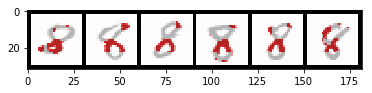

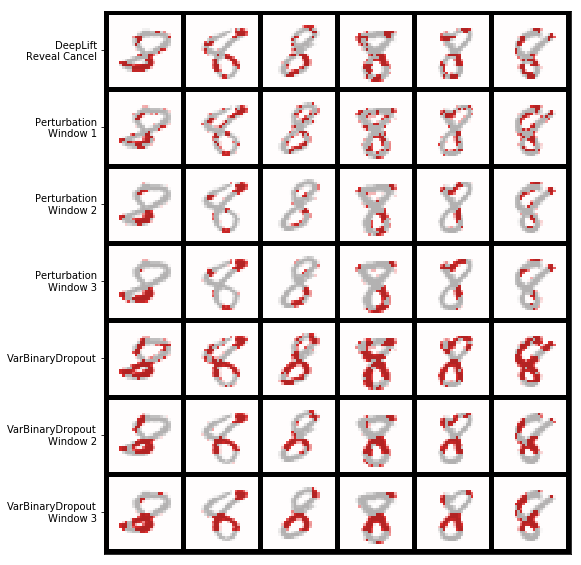

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[27.89935302734375, 36.28497123718262, 31.197514057159424, 40.66431736946106, 17.985346794128418, 42.698673486709595]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[24.807863235473633, 33.19512128829956, 32.256168365478516, 37.49858593940735, 17.43417263031006, 42.364611744880676]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[23.582753658294678, 32.030921936035156, 33.86270713806152, 36.7184898853302, 21.798458099365234, 42.529927492141724]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[44.41458702087402, 53.11967468261719, 47.85079383850098, 54.194759368896484, 36.19278812408447, 56.569549560546875]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[44.93417549133301, 57.5385627746582, 47.26488494873047, 58.487640380859375, 36.34828853607178, 60.69178581237793]
load mnist test ima

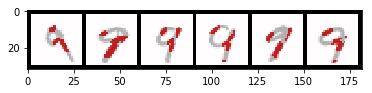

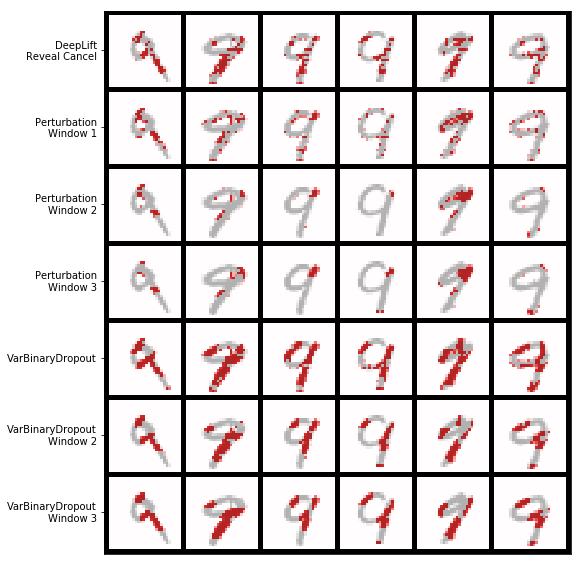

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[30.31672239303589, 24.53946018218994, 19.804434299468994, 18.2569260597229, 37.02399921417236, 38.048133850097656]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[31.3474178314209, 25.39555048942566, 19.219825506210327, 18.94027328491211, 36.110456228256226, 39.97330713272095]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[33.84558868408203, 25.34283971786499, 19.373738765716553, 19.77643084526062, 35.79513740539551, 41.122779846191406]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[21.693963050842285, 34.13958930969238, 21.781994342803955, 19.864721059799194, 36.16090679168701, 41.29780197143555]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[37.03552532196045, 33.80460548400879, 26.11549997329712, 22.828176975250244, 44.6285924911499, 45.75471782684326]
load mnist test image. 

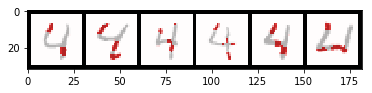

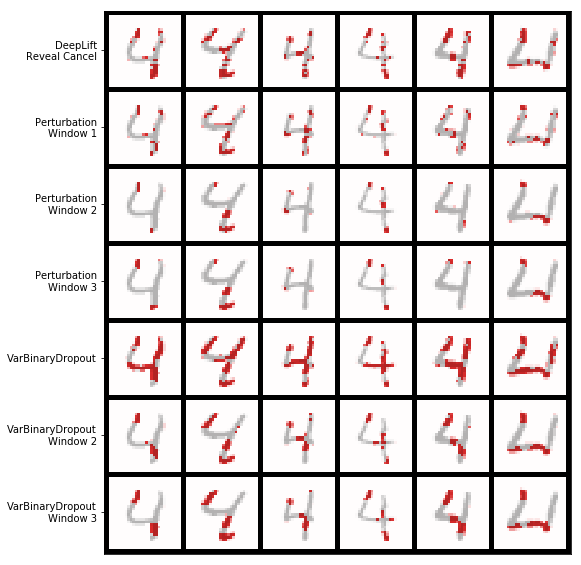

In [12]:
visualize(8, 6, num_imgs=6)
visualize(9, 1, num_imgs=6)
visualize(4, 1, num_imgs=6)

## The rest is the prvious results / testing

In [ ]:
revealcancel_masked = get_top_masked_images(8, 3, num_imgs=6)

### Plot results of my model

cuda: False
Namespace(cuda=False, from_digit=8, l1_reg_coef=0.1, l2_reg_coef=0.0, model='vbd', no_cuda=True, to_digit=3, top_n=1, verbose=1, visualize=True, window=2)


In [71]:
args.top_n = 6
args.verbose = 0
args.model = 'p_b'

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[35.25962543487549, 32.62545680999756, 30.904804706573486, 38.2468147277832, 32.7720308303833, 34.618680000305176]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[29.21548080444336, 31.512510299682617, 32.51145935058594, 37.68375492095947, 32.39821434020996, 37.863059997558594]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[54.87270545959473, 47.32833671569824, 58.63725662231445, 66.28828048706055, 56.16657638549805, 57.55338096618652]


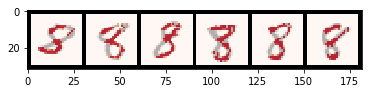

In [38]:
results = OrderedDict()
args.window = 1
diff, overlayed_imgs = run(args)
results['Perturbation\nWindow 1'] = overlayed_imgs
args.window = 2
diff, overlayed_imgs = run(args)
results['Perturbation\nWindow 2'] = overlayed_imgs
args.window = 3
diff, overlayed_imgs = run(args)
results['Perturbation\nWindow 3'] = overlayed_imgs

args.window = 1
args.model = 'vbd'
diff, overlayed_imgs = run(args)
results['VarBinaryDropout'] = overlayed_imgs

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[54.89868354797363, 47.052175521850586, 58.61756896972656, 65.80858612060547, 56.03395080566406, 57.76477813720703]


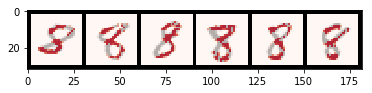

In [81]:
args.window = 2
args.model = 'vbd_window'
diff, overlayed_imgs = run(args)
results['VarBinaryDropout\nWindow 2'] = overlayed_imgs

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.44941494  0.40660546  0.36482689  0.36775461  0.39201026  0.46091443
   0.51276336  0.4801380

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

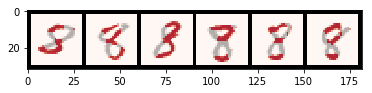

In [84]:
args.window = 3
args.model = 'vbd_window'
diff, overlayed_imgs = run(args)
results['VarBinaryDropout\n Window 3'] = overlayed_imgs

In [85]:
ordered_result = OrderedDict()
ordered_result['DeepLift'] = revealcancel_masked
ordered_result['Perturbation\nWindow 1'] = results['Perturbation\nWindow 1']
ordered_result['Perturbation\nWindow 2'] = results['Perturbation\nWindow 2']
ordered_result['Perturbation\nWindow 3'] = results['Perturbation\nWindow 3']
ordered_result['VarBinaryDropout'] = results['VarBinaryDropout']
ordered_result['VarBinaryDropout\nWindow 2'] = results['VarBinaryDropout\nWindow 2']
ordered_result['VarBinaryDropout\n Window 3'] = results['VarBinaryDropout\n Window 3']

([<matplotlib.axis.YTick at 0x7f1fb3ab1f90>,
 <a list of 7 Text yticklabel objects>)

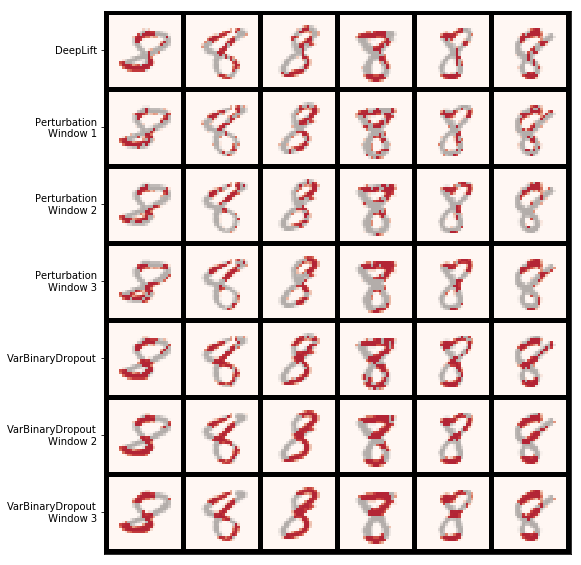

In [86]:
import exp.utils_visualise as utils_visualize

vals = []
for v in ordered_result.values():
    vals += v

plt.figure(figsize=(15,10))
utils_visualize.save_figs(vals, filename='', visualize=True, nrow=6)
plt.xticks([])

labels = ordered_result.keys()
pos = [15 + i * 30 for i in xrange(len(labels))]
plt.yticks(pos, labels)

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[38.384214878082275, 19.3890061378479, 33.40637731552124, 36.77999806404114, 33.597527503967285, 30.520543575286865]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[34.246567726135254, 23.37331986427307, 33.23188304901123, 37.893956422805786, 36.19549751281738, 29.005367755889893]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[33.73488998413086, 19.798469066619873, 30.797911643981934, 33.810513973236084, 30.435919761657715, 25.032588005065918]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[50.34974956512451, 36.37283134460449, 45.66799831390381, 48.777119636535645, 43.17183589935303, 37.04154062271118]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.55018593  0.60150257  0.65334998  0.65469054  0.65510881  0.55286618
   0.44967613  0.3472175

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

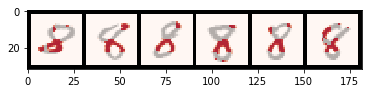

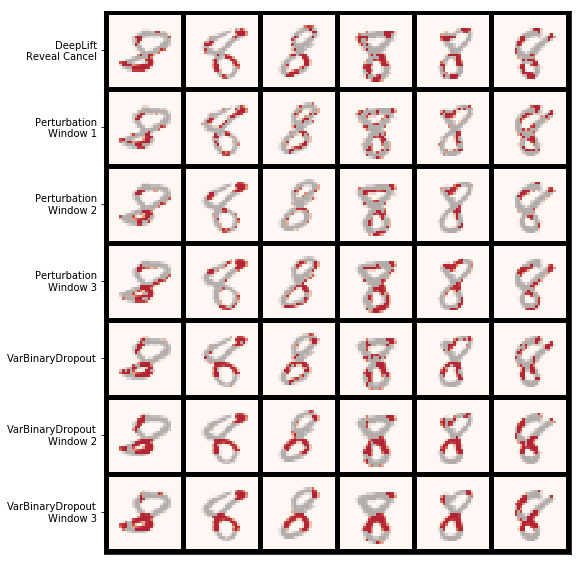

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[27.89935302734375, 36.28497123718262, 31.197514057159424, 40.66431736946106, 17.985346794128418, 42.698673486709595]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[25.555262565612793, 37.51778221130371, 31.40349578857422, 37.48444366455078, 18.13467764854431, 43.12726092338562]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[24.37268304824829, 31.078647136688232, 27.681503295898438, 39.12337684631348, 15.040255069732666, 40.767019271850586]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[47.41068649291992, 59.71538734436035, 50.99460029602051, 60.788509368896484, 39.795188903808594, 62.224159240722656]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

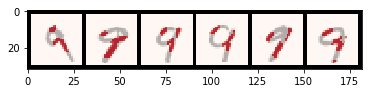

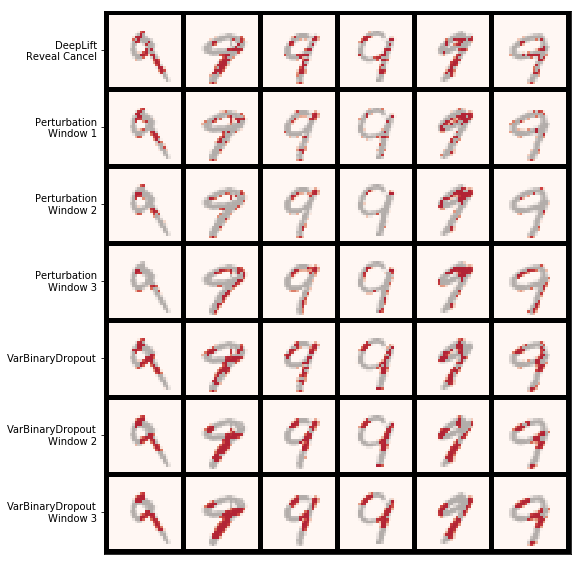

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[30.31672239303589, 24.53946018218994, 19.804434299468994, 18.2569260597229, 37.02399921417236, 38.048133850097656]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[31.222756147384644, 24.865190029144287, 19.387174129486084, 18.498428344726562, 35.14684009552002, 36.22722244262695]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[31.590916395187378, 24.843994617462158, 19.081282138824463, 18.63857650756836, 35.10153079032898, 38.434978008270264]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[37.36358070373535, 37.60792350769043, 27.84888458251953, 24.18985366821289, 45.86438179016113, 47.0533561706543]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5    

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

H: 28 W: 28
H: 28 W: 26
H: 26 W: 28
H: 26 W: 26
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5 

[36.98439693450928, 33.31902313232422, 25.94856357574463, 22.81262969970703, 44.53904724121094, 45.75471782684326]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5        

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5 

H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 27 W: 27
H: 27 W: 27
H: 27 W: 24
H: 24 W: 27
H: 24 W: 27
H: 24 W: 24
[[ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.55053402  0.60093446  0.65171786  0.65228516  0.60188472
   0.55110131  0.5         0.5         0.5         0.5         0.5         0.5
   0.5      

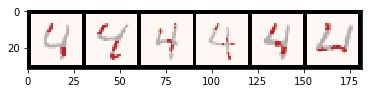

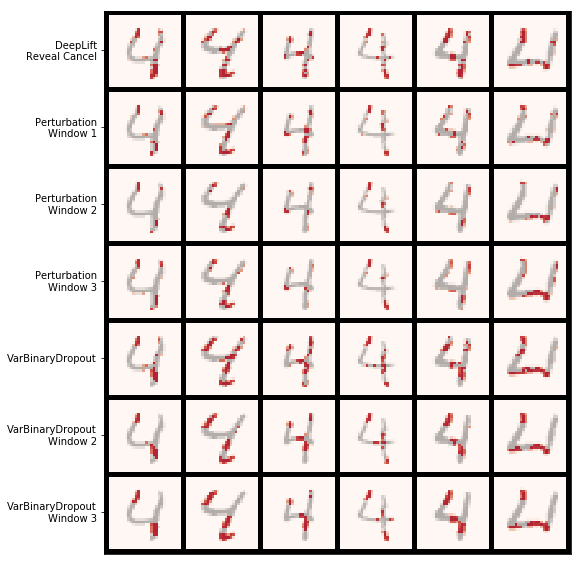

In [88]:
visualize(8, 6, num_imgs=6)
visualize(9, 1, num_imgs=6)
visualize(4, 1, num_imgs=6)

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[37.61988639831543, 31.787724494934082, 34.9098424911499, 38.2768497467041, 32.07139444351196, 33.642030239105225]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[35.25962543487549, 32.62545680999756, 30.904804706573486, 38.2468147277832, 32.7720308303833, 34.618680000305176]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[29.21548080444336, 31.512510299682617, 32.51145935058594, 37.68375492095947, 32.39821434020996, 37.863059997558594]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[54.89868354797363, 47.32833671569824, 58.63725662231445, 66.15735626220703, 56.0647029876709, 57.71187782287598]


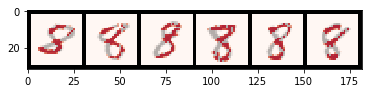

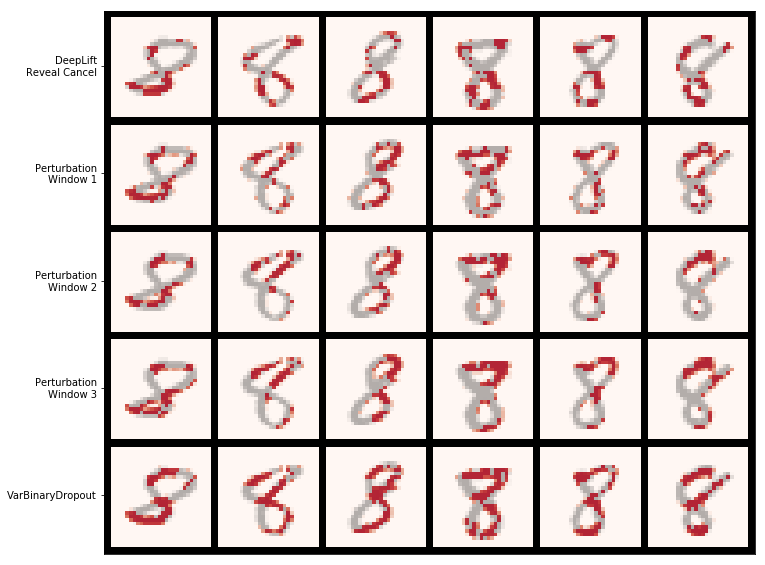

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[37.61988639831543, 31.787724494934082, 34.9098424911499, 38.2768497467041, 32.07139444351196, 33.642030239105225]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[35.25962543487549, 32.62545680999756, 30.904804706573486, 38.2468147277832, 32.7720308303833, 34.618680000305176]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[29.21548080444336, 31.512510299682617, 32.51145935058594, 37.68375492095947, 32.39821434020996, 37.863059997558594]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[54.89868354797363, 47.3797550201416, 58.08070945739746, 66.25091934204102, 56.16657638549805, 57.68083953857422]


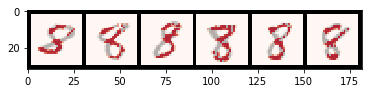

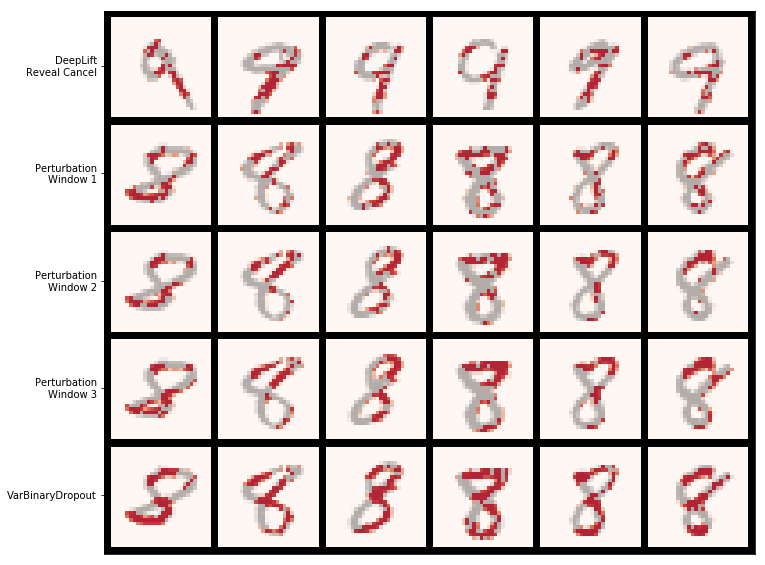

load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[37.61988639831543, 31.787724494934082, 34.9098424911499, 38.2768497467041, 32.07139444351196, 33.642030239105225]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[35.25962543487549, 32.62545680999756, 30.904804706573486, 38.2468147277832, 32.7720308303833, 34.618680000305176]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[29.21548080444336, 31.512510299682617, 32.51145935058594, 37.68375492095947, 32.39821434020996, 37.863059997558594]
load mnist test image. shape: (10000, 1, 28, 28), min: 0.000000, max: 1.000000
[54.89868354797363, 47.3797550201416, 58.583126068115234, 66.06433486938477, 56.03427696228027, 57.89326477050781]


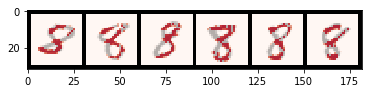

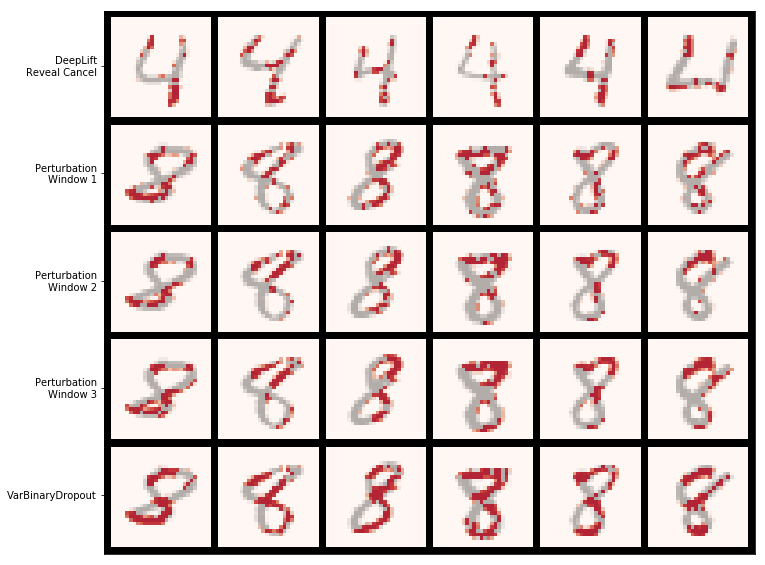

In [65]:
visualize(8, 6, num_imgs=6)
visualize(9, 1, num_imgs=6)
visualize(4, 1, num_imgs=6)